In [1]:
import kagglehub
import os

# Download dataset
dataset_path = kagglehub.dataset_download("hieuvuvan/atopicdermatitis")
print("Dataset path:", dataset_path)
print("Contents inside dataset folder:", os.listdir(dataset_path))


100%|██████████| 5.07M/5.07M [00:00<00:00, 20.7MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/hieuvuvan/atopicdermatitis/versions/1
Contents inside dataset folder: ['not_AD', 'AD']


In [2]:
import shutil, os

base_dir = dataset_path

# If both 'Not_AD' and 'not_AD' exist, merge them
if "Not_AD" in os.listdir(base_dir) and "not_AD" in os.listdir(base_dir):
    src = os.path.join(base_dir, "not_AD")
    dst = os.path.join(base_dir, "Not_AD")
    for f in os.listdir(src):
        src_file = os.path.join(src, f)
        dst_file = os.path.join(dst, f)
        if not os.path.exists(dst_file):  # Avoid overwrite
            shutil.move(src_file, dst)
    shutil.rmtree(src)

# If only 'not_AD' exists, rename it
elif "not_AD" in os.listdir(base_dir):
    os.rename(os.path.join(base_dir, "not_AD"), os.path.join(base_dir, "Not_AD"))

print("✅ After cleanup:", os.listdir(base_dir))


✅ After cleanup: ['Not_AD', 'AD']


In [3]:
import os, shutil
from sklearn.model_selection import train_test_split

raw_data_dir = base_dir
dataset_root = "/content/dataset"
classes = ["AD", "Not_AD"]
splits = ["train", "val", "test"]

# Create new structure
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(dataset_root, split, cls), exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Copy images
for cls in classes:
    cls_dir = os.path.join(raw_data_dir, cls)
    images = [img for img in os.listdir(cls_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    train_files, temp_files = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

    for f in train_files:
        shutil.copy(os.path.join(cls_dir, f), os.path.join(dataset_root, "train", cls, f))
    for f in val_files:
        shutil.copy(os.path.join(cls_dir, f), os.path.join(dataset_root, "val", cls, f))
    for f in test_files:
        shutil.copy(os.path.join(cls_dir, f), os.path.join(dataset_root, "test", cls, f))

print("✅ Dataset split complete!")


✅ Dataset split complete!


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_root, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_root, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_root, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 131 images belonging to 2 classes.
Found 29 images belonging to 2 classes.
Found 29 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5419 - loss: 0.7971 - val_accuracy: 0.5862 - val_loss: 0.6053
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5993 - loss: 0.6942 - val_accuracy: 0.6207 - val_loss: 0.5845
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 857ms/step - accuracy: 0.5956 - loss: 0.7078 - val_accuracy: 0.7241 - val_loss: 0.5690
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 856ms/step - accuracy: 0.6268 - loss: 0.6806 - val_accuracy: 0.7586 - val_loss: 0.5574
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6255 - loss: 0.7365 - val_accuracy: 0.7586 - val_loss: 0.5471


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.0564516129032258), 1: np.float64(0.9492753623188406)}


In [7]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights
)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6058 - loss: 0.6636 - val_accuracy: 0.7586 - val_loss: 0.5172
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5706 - loss: 0.6986 - val_accuracy: 0.7586 - val_loss: 0.4932
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6680 - loss: 0.6202 - val_accuracy: 0.7931 - val_loss: 0.4711
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7411 - loss: 0.5417 - val_accuracy: 0.8276 - val_loss: 0.4535
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6873 - loss: 0.5737 - val_accuracy: 0.8276 - val_loss: 0.4395
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7588 - loss: 0.5154 - val_accuracy: 0.8276 - val_loss: 0.4248
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 986ms/step - accuracy: 0.7966 - loss: 0.5440 - val_accuracy: 0.8621 - val_loss: 0.4133
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8077 - loss: 0.4651 - val_accuracy: 0.8621 - val_loss: 0.4037
Epoch 9

Class indices: {'AD': 0, 'Not_AD': 1}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
              precision    recall  f1-score   support

          AD       0.73      0.79      0.76        14
      Not_AD       0.79      0.73      0.76        15

    accuracy                           0.76        29
   macro avg       0.76      0.76      0.76        29
weighted avg       0.76      0.76      0.76        29

AUC: 0.8381


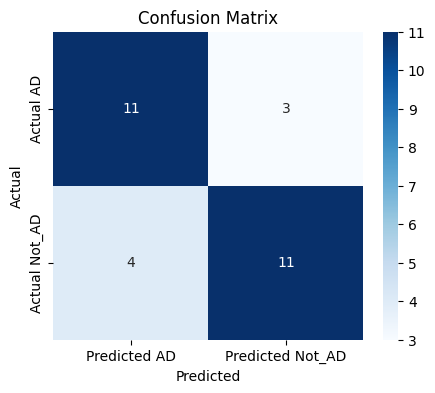

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Class indices:", test_generator.class_indices)

y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred, target_names=['AD', 'Not_AD']))
print(f"AUC: {roc_auc_score(y_true, y_pred_prob):.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted AD', 'Predicted Not_AD'],
            yticklabels=['Actual AD', 'Actual Not_AD'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
